In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from scipy import stats

In [2]:
#LEO ARCHIVOS
infile_bi = "sdss_bi_iPp0.00.MAG"

infile_g_hold = "data_g_hold_con_error.txt"
infile_i_hold = "data_i_hold_con_error.txt"
infile_r_hold = "data_r_hold_con_error.txt"
infile_i = "data_i_con_error.txt"
infile_r = "data_r_con_error.txt"

In [3]:
#LE ASOCIO COLUMNAS
data_g_hold = np.genfromtxt(infile_g_hold, comments='#')[:,0:]
data_i_hold = np.genfromtxt(infile_i_hold, comments='#')[:,0:]
data_r_hold = np.genfromtxt(infile_r_hold, comments='#')[:,0:]
data_i = np.genfromtxt(infile_i, comments='#')[:,0:]
data_r = np.genfromtxt(infile_r, comments='#')[:,0:]

#ASOCIO VARIABLES A COLUMNAS
data_g_hold_data = data_g_hold[:, 1]
data_g_hold_data_error = data_g_hold[:, 2]
data_i_hold_data = data_i_hold[:, 1]
data_i_hold_data_error = data_i_hold[:, 2]
data_r_hold_data = data_r_hold[:, 1]
data_r_hold_data_error = data_r_hold[:, 2]
data_i_data = data_i[:, 1]
data_r_data = data_r[:, 1]

En el archivo del modelo bimodal viene ordenado por metalicidades, pero las metalicidades
se repiten en bloques de 7.

Primero, como ya está ordenado Z parto en bloques cada vez que cambia la metalicidad, sabiendo que esta cambia cada 50 valores. Obtengo 98 tablas en bloques de 7 metalicidades que se van repitiendo.

Segundo, me hace falta ordenar por edades, por tanto lo que hago es hacer bloques de las 7 metalicidades sin repetir y luego ordenar esta por edades, que se repiten cada 7 valores. Entonces hago tablas de edades iguales para cada bloque de 7, al final hay 700 tablas

In [4]:
#ESTUDIO DE LOS DISTINTOS MODELOS PARA Z FIJO
df_bi = pd.read_csv(infile_bi, sep=' ')
df_bi = df_bi.drop(columns={"mu","M(*+remn)","u_SDSS","z_SDSS","ML(u_SDSS)","ML(u_SDSS)","ML(g_SDSS)","ML(r_SDSS)","ML(i_SDSS)","ML(z_SDSS)"})
df_bi_z = df_bi #HASTA 350 NO SE REPITEN METALICIDADES

#PROPIEDADES DEL FICHERO, 50 VALORES DE CADA METALICIDAD, 7 VALORES DE LA METALICIDAD
#ANTES DE REPETIR -> LINEAS SIN REPETIR = VALORES POR METALICIDAD*NUMERO METALICIDADES
#NUM TABLAS = NUMERO DE DATOS ENTRE LA SEPARACION ENTRE METALICIDADES
separacion = 50
bloques_sin_repetir = 7 
lines_sin_rep = 50*7
n_tablas_z = len(df_bi_z)/separacion
####
####

rest_z = df_bi_z
tablas_z = [] #LO DEFINO VACIO PARA PODER LLENARLO LUEGO
tablas_z.append(rest_z[:50])
        
#COMO EL FICHERO VIENE SEPARADO EN METALICIDADES Y ESTAS CAMBIAN DE VALOR CADA 50 VALORES
#CREO UNA TABLA CADA 50 VALORES
for i in np.arange(0, n_tablas_z, 1):
    if df_bi_z.shape[0] > 50: 
        rest_z = rest_z[50:]
        tablas_z.append(rest_z[:50])

#CREO LA COLUMNA RESTA DE COLORES PARA Z
for i in np.arange(0, n_tablas_z, 1):
    tablas_aux = tablas_z[int(i)]
    tablas_aux["g-r"] = tablas_aux['g_SDSS'] - tablas_aux['r_SDSS']
    tablas_z[int(i)] = tablas_aux
    tablas_aux["r-i"] = tablas_aux['r_SDSS'] - tablas_aux['i_SDSS']
    tablas_z[int(i)] = tablas_aux

#COSAS DE LA EDAD  
df_bi_age = df_bi_z
n_tablas_para_ordenar = len(df_bi_age)/lines_sin_rep 
rest = df_bi_age
tablas_age_para_ordenar = []

#PRIMERO PARTO EN BLOQUES DE 7 METALICIDADES SIN REPETIR, CREO TABLAS DE 350 VALORES PARA 
#METALICIDADES DIFERENTES DE UN MODELO
tablas_age_para_ordenar.append(rest[:lines_sin_rep])#RELLENO CON LOS PRIMEROS DATOS

#RELLENO EL RESTO
for i in np.arange(1, n_tablas_para_ordenar, 1):
    if df_bi_age.shape[0] > lines_sin_rep : 
        rest = rest[lines_sin_rep :]
        tablas_age_para_ordenar.append(rest[:lines_sin_rep])
##############        
#HASTA AQUI HE DIVIDIDO TABLAS POR MODELOS, PERO NO ESTAN ORDENADAS POR EDADES  
##############

#ORDENO LAS TABLAS PARTIDAS EN MODELOS POR EDAD
tablas_age_ordenada = []
for i in np.arange(0, n_tablas_para_ordenar, 1):        
    tablas_age_ordenada.append(tablas_age_para_ordenar[int(i)].sort_values(by = 'Age', ascending = True)) #Los ordenamos por edades
    tablas_age_ordenada[int(i)] = tablas_age_ordenada[int(i)].reset_index(drop = True) #Iniciamos indices despues del sort

#CREO TABLAS PARA CADA GRUPO DE EDAD SEPARADOS POR GRUPOS DE METALICIDADES 
#QUE YA HEMOS REORDENADO  
rest_age = pd.DataFrame()
tablas_age = [] 

for j in np.arange(0,len(tablas_age_ordenada),1): #MUEVE LOS BLOQUES SIN REPETIR
    n_tablas_age = len(tablas_age_ordenada[j])/7
    rest_age = tablas_age_ordenada[j]
    tablas_age.append(rest_age[:7])

    for i in np.arange(1, n_tablas_age, 1): #MUEVE LAS EDADES DENTRO DE UN BLOQUE DE MODELO DADO
        if tablas_age_ordenada[j].shape[0] > 7: 
            rest_age = rest_age[7:]
            tablas_age.append(rest_age[:7])
            
#CREO LA COLUMNA RESTA DE COLORES PARA AGE
for i in np.arange(0, 700, 1):
    tablas_aux = tablas_age[int(i)]
    tablas_aux["g-r"] = tablas_aux['g_SDSS'] - tablas_aux['r_SDSS']
    tablas_age[int(i)] = tablas_aux
    tablas_aux["r-i"] = tablas_aux['r_SDSS'] - tablas_aux['i_SDSS']
    tablas_age[int(i)] = tablas_aux

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

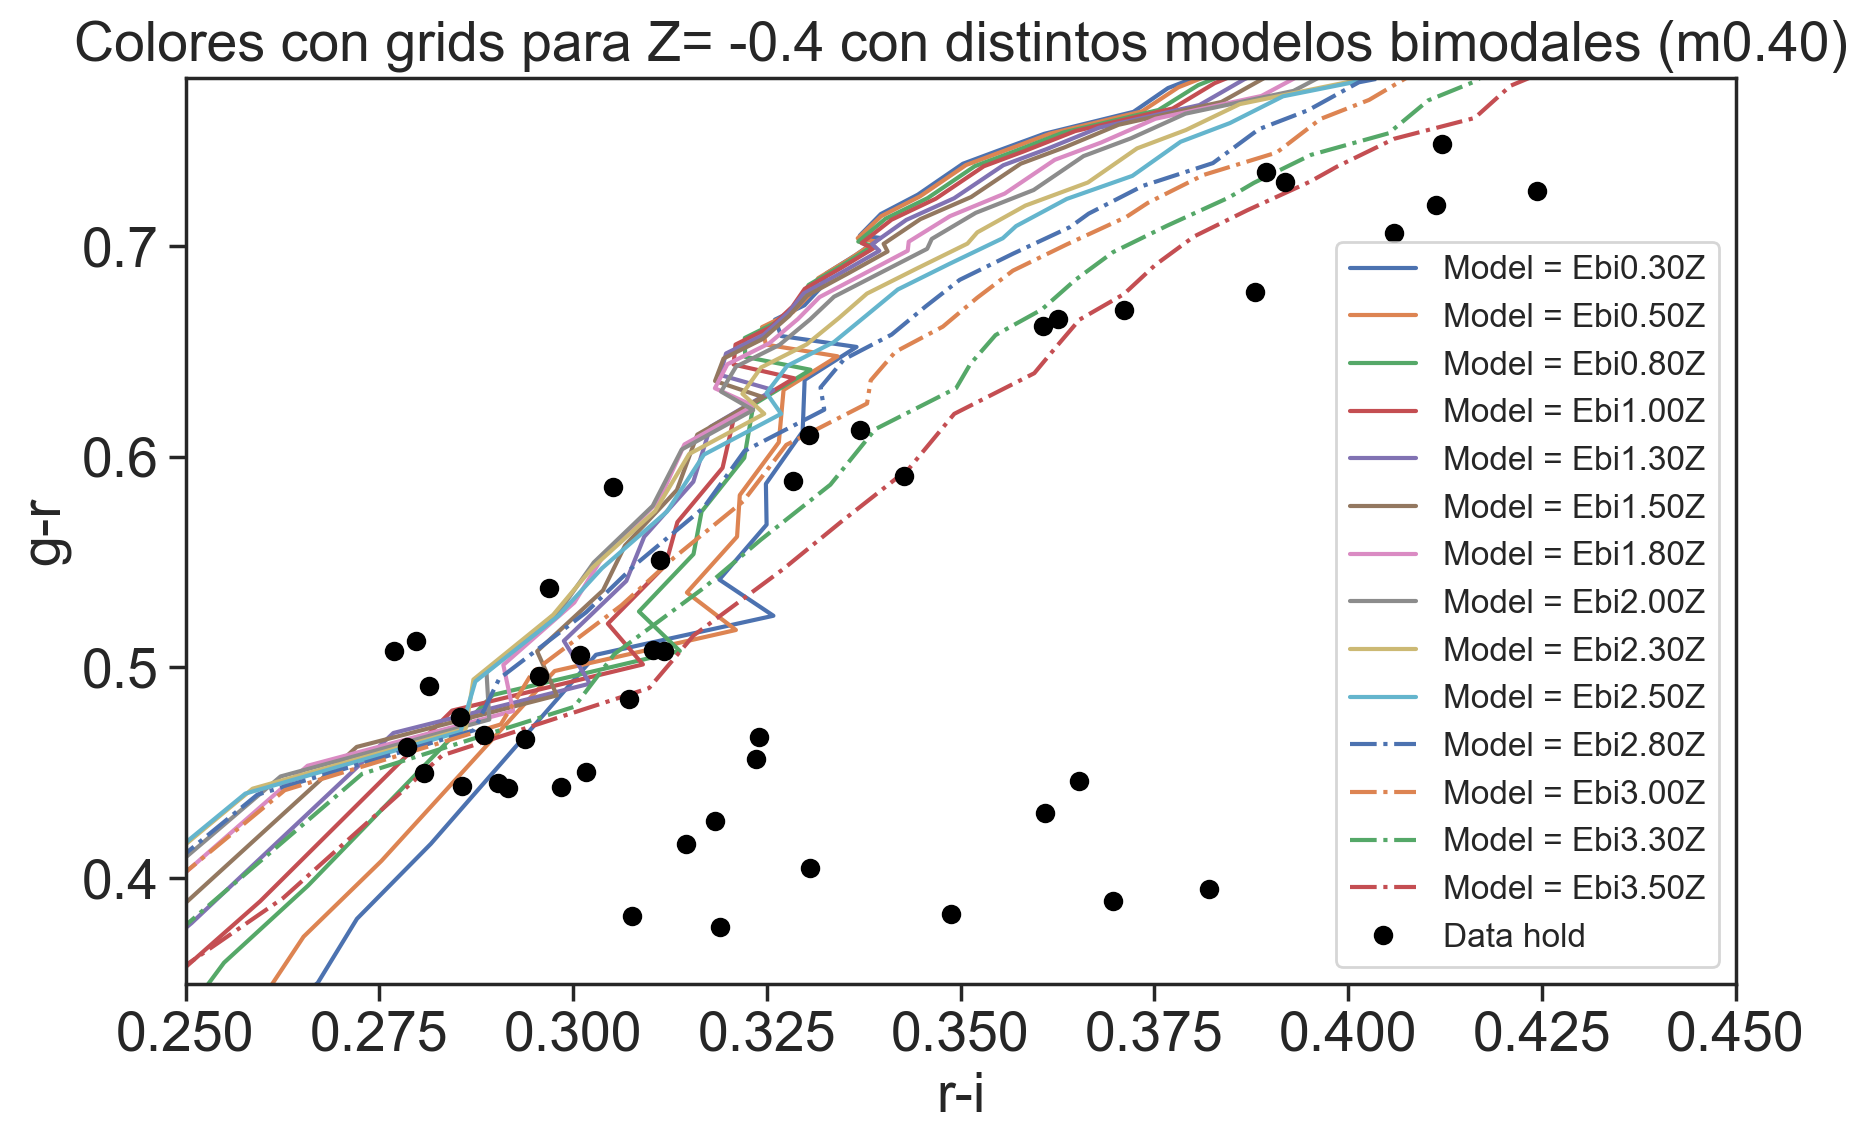

In [5]:
#ESTUDIO DE DISTINTAS IMF PARA Z

sns.set(color_codes=True)
sns.set_style("ticks")
sns.set_context("paper")
sns.set(style="ticks")

fig = plt.figure(figsize=(10, 6), dpi = 200) # Create a figure of size 8x6 inches, 200 dots per inch
ax = fig.add_subplot(1,1,1)

model_label = ["Ebi0.30Z","Ebi0.50Z","Ebi0.80Z","Ebi1.00Z","Ebi1.30Z","Ebi1.50Z","Ebi1.80Z","Ebi2.00Z","Ebi2.30Z","Ebi2.50Z","Ebi2.80Z","Ebi3.00Z","Ebi3.30Z","Ebi3.50Z"]
aux_label = 0
line_st = ["-","-","-","-","-","-","-","-","-","-","-.","-.","-.","-.","-."]

n_tab_z = np.arange(4,100,7)
for i in n_tab_z:
    tabla_aux = tablas_z[int(i)]
    z_mean = tabla_aux["Z"].mean()
    ax.plot(tablas_z[int(i)]["r-i"], tablas_z[int(i)]["g-r"],  linestyle= line_st[aux_label], linewidth=1.5, label = "Model = {}".format(model_label[aux_label]))
    aux_label = aux_label + 1
    
ax.plot(data_r_hold_data - data_i_hold_data,data_g_hold_data - data_r_hold_data,"o", color = "black",label="Data hold")

ax.set_ylim(0.35, 0.78)
ax.set_xlim(0.25, 0.45)
ax.set_title('Colores con grids para Z= {} con distintos modelos bimodales (m0.40)'.format(round(z_mean,2)),fontsize = 20)
ax.set_ylabel('g-r',fontsize = 20)
ax.set_xlabel('r-i',fontsize = 20)
ax.tick_params(labelsize=20)
ax.legend(loc='lower right',fontsize = 12)

plt.savefig("z_distintos_modelos.png")
plt.show()

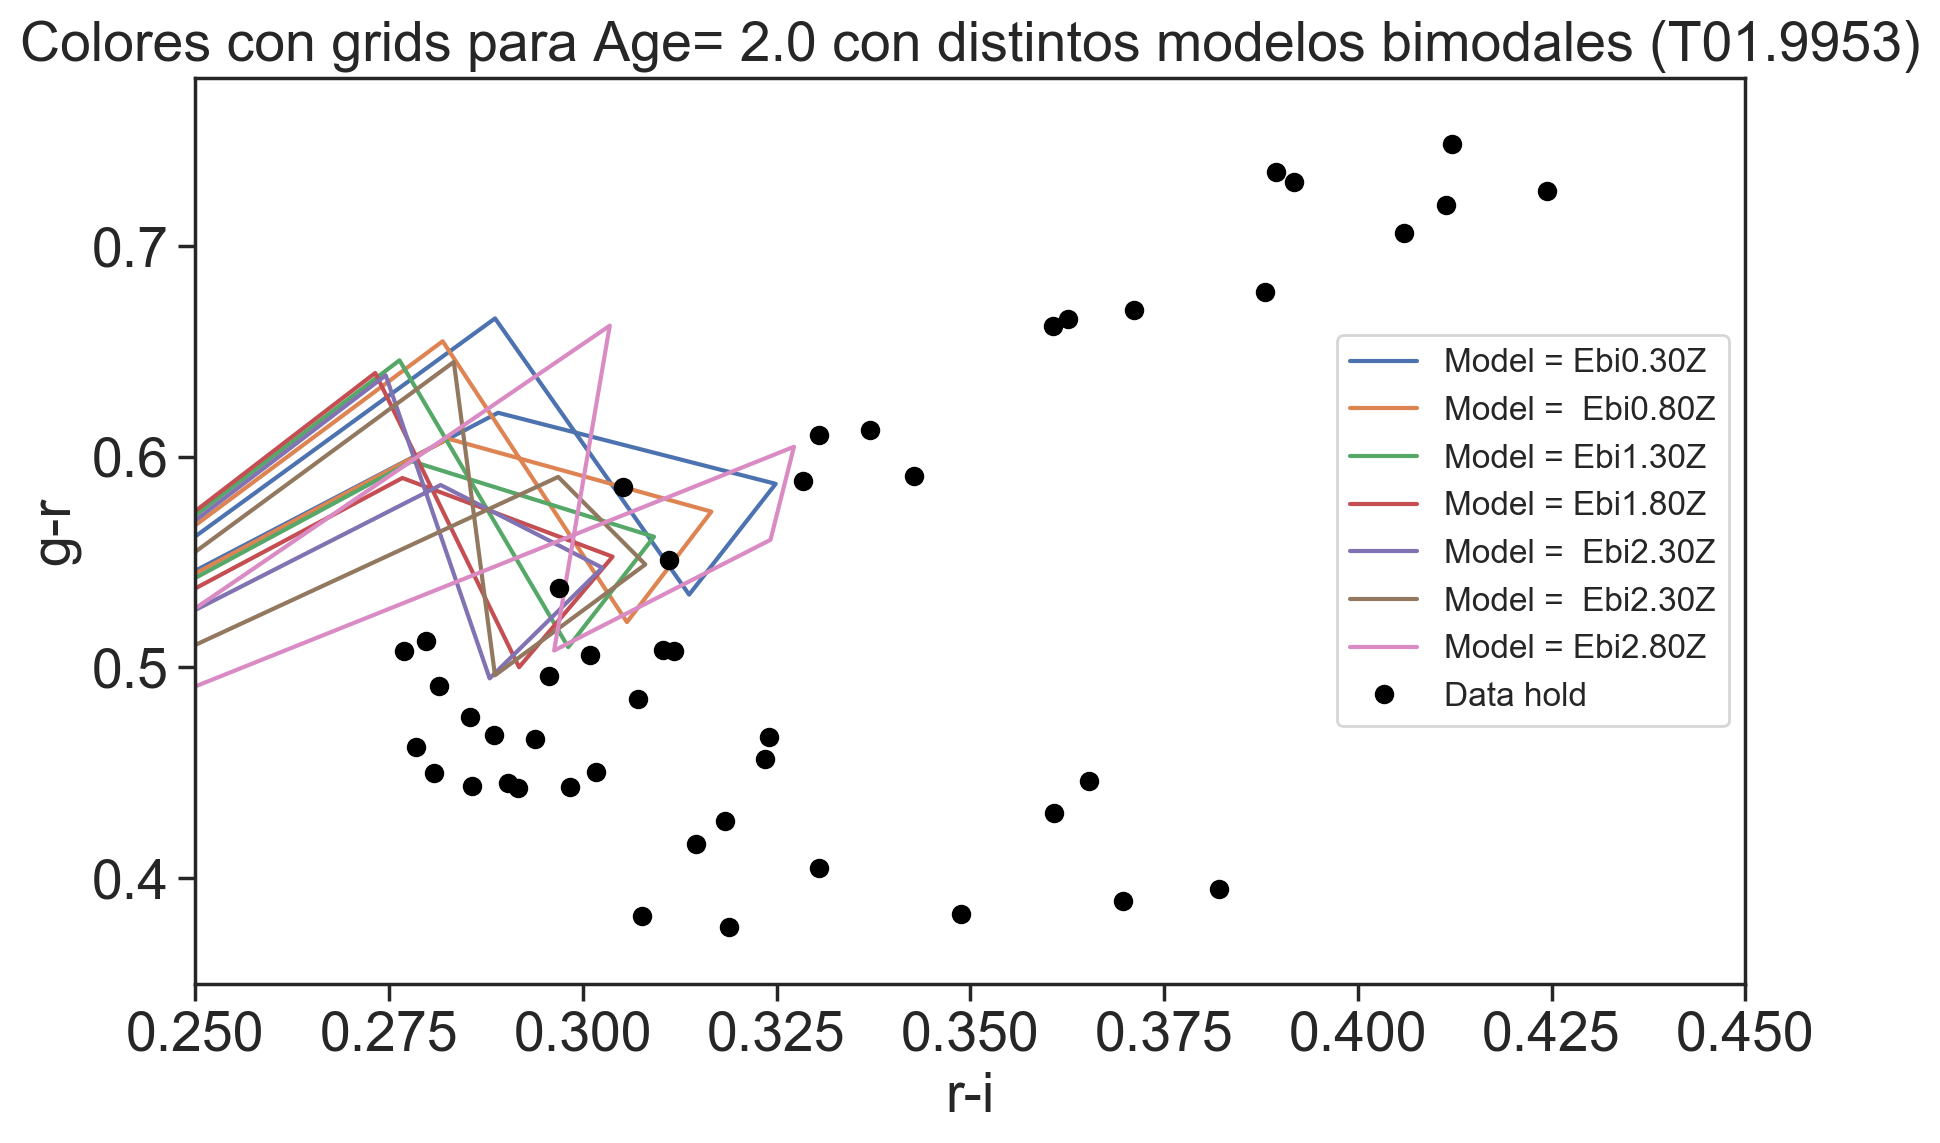

In [6]:
#ESTUDIO DE DISTINTAS IMF PARA AGE
sns.set(color_codes=True)
sns.set_style("ticks")
sns.set_context("paper")
sns.set(style="ticks")

fig = plt.figure(figsize=(10, 6), dpi = 200) # Create a figure of size 8x6 inches, 80 dots per inch
ax = fig.add_subplot(1,1,1)
    
model_label = ["Ebi0.30Z"," Ebi0.80Z","Ebi1.30Z","Ebi1.80Z"," Ebi2.30Z"," Ebi2.30Z","Ebi2.80Z","Ebi3.30Z"]
aux_label = 0
line_st = ["-","-","-","-","-","-","-","-","-","-","-.","-.","-.","-.","-."]
n_tab_age = np.arange(30,700,100)

for i in n_tab_age: 
    tabla_aux = tablas_age[int(i)]
    age_mean = tabla_aux["Age"].mean()
    ax.plot(tablas_age[int(i)]["r-i"], tablas_age[int(i)]["g-r"],  
            linestyle= line_st[aux_label],
            linewidth=1.5, 
            label = "Model = {}".format(model_label[aux_label]))
    aux_label = aux_label + 1
    
ax.plot(data_r_hold_data - data_i_hold_data,data_g_hold_data - data_r_hold_data,"o", color = "black",label="Data hold")

ax.set_ylim(0.35, 0.78)
ax.set_xlim(0.25, 0.45)
ax.set_title('Colores con grids para Age= {} con distintos modelos bimodales (T01.9953)'.format(round(age_mean,2)),fontsize = 20)
ax.set_ylabel('g-r',fontsize = 20)
ax.set_xlabel('r-i',fontsize = 20)
ax.tick_params(labelsize=20)
ax.legend(loc='center right',fontsize = 12)

plt.savefig("age_distintos_modelos.png")
plt.show()

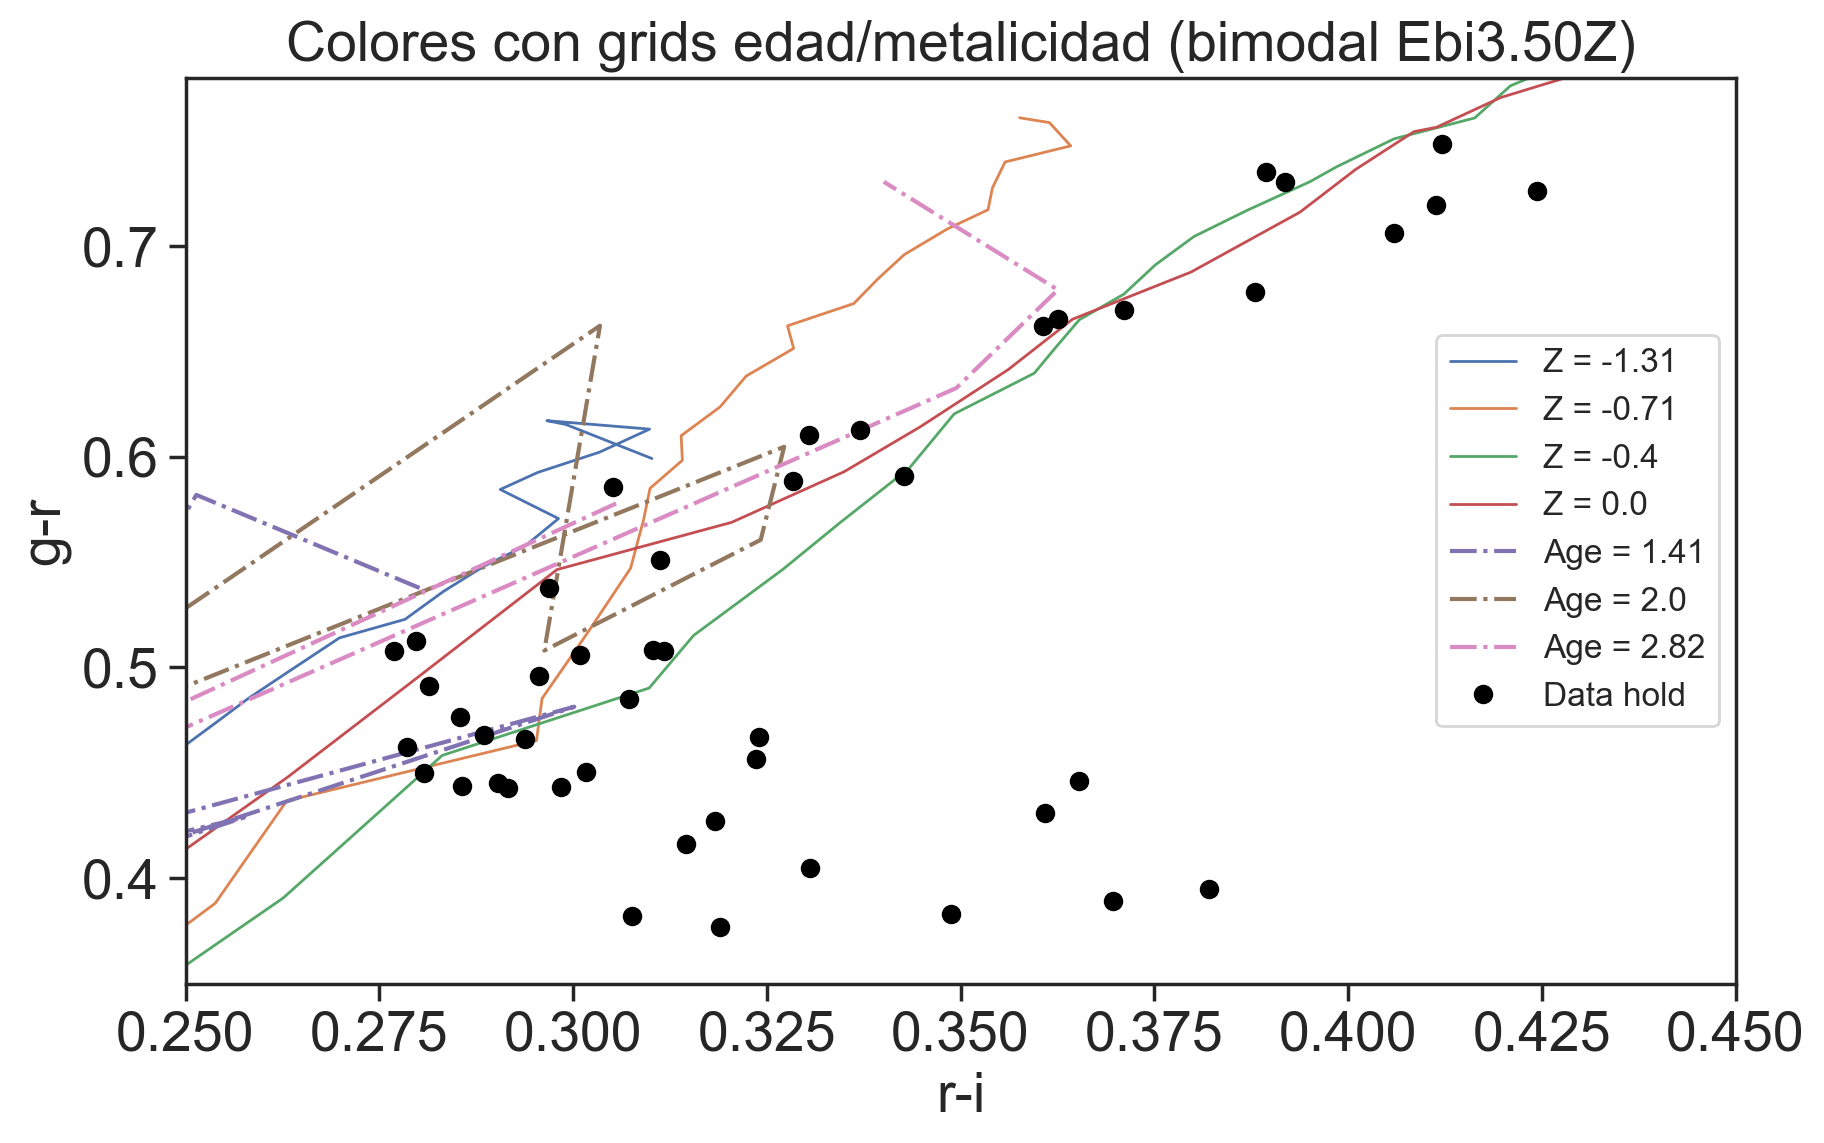

In [7]:

sns.set(color_codes=True)
sns.set_style("ticks")
sns.set_context("paper")
sns.set(style="ticks")

fig = plt.figure(figsize=(10, 6), dpi=200) # Create a figure of size 8x6 inches, 80 dots per inch
ax = fig.add_subplot(1,1,1)

n_tab_z = np.arange(93,97,1)
for i in n_tab_z:
    tabla_aux = tablas_z[int(i)]
    z_mean = tabla_aux["Z"].mean()
    ax.plot(tablas_z[int(i)]["r-i"], tablas_z[int(i)]["g-r"], linewidth=1, linestyle="-", label = "Z = {}".format(round(z_mean, 2)))
  

#n_tab_age = [26,28,30,32,34]
n_tab_age = [627,630,633]
for i in n_tab_age:
    tabla_aux = tablas_age[int(i)]
    age_mean = tabla_aux["Age"].mean()
    ax.plot(tablas_age[int(i)]["r-i"], tablas_age[int(i)]["g-r"], linewidth=1.5, linestyle="-.", label = "Age = {}".format(round(age_mean, 2)))
    
    
ax.plot(data_r_hold_data - data_i_hold_data,data_g_hold_data - data_r_hold_data,"o", color = "black",label="Data hold")

ax.set_ylim(0.35, 0.78)
ax.set_xlim(0.25, 0.45)
ax.tick_params(labelsize=20)
ax.set_title('Colores con grids edad/metalicidad (bimodal Ebi3.50Z)',fontsize = 20)
ax.set_ylabel('g-r',fontsize = 20)
ax.set_xlabel('r-i',fontsize = 20)

ax.legend(loc='center right',fontsize = 12)
plt.savefig("z.png")
plt.show()